## Imports

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score

import sys
import pickle
import wandb

import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.utils import to_networkx
import torch.nn as nn
from torch.nn import Sequential, Linear
import matplotlib.pyplot as plt
import networkx as nx

from utils.miscellaneous import read_config
from utils.miscellaneous import create_folder_structure_MLPvsGNN
from utils.miscellaneous import initalize_random_generators

from training.train import training
from training.test import testing

from utils.visualization import plot_R2, plot_loss

wandb.init(project="Unrolling WDNs", entity="albert-sola9")

wandb: Currently logged in as: albert-sola9. Use `wandb login --relogin` to force relogin


### Parse configuration file + initializations


In [2]:
# read config files
cfg = read_config("config_unrolling.yaml")
# create folder for results
exp_name = cfg['exp_name']
data_folder = cfg['data_folder']
results_folder = create_folder_structure_MLPvsGNN(cfg, parent_folder='./experiments')


all_wdn_names = cfg['networks']
initalize_random_generators(cfg, count=0)

# initialize pytorch device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device ='cpu'
print(device)
#torch.set_num_threads(12)

Creating folder: ./experiments/unrolling_WDN0016
cuda:0


In [3]:
# TO DO: at the moment I am not using the parsed values for batch size and num_epochs ;
# I am not using alpha as well because the loss has no "smoothness" penalty (yet)
batch_size = cfg['trainParams']['batch_size']
alpha = cfg['lossParams']['alpha']
res_columns = ['train_loss', 'valid_loss','test_loss', 'r2_train', 'r2_valid',
               'r2_test','total_params','total_time','test_time','num_epochs']

# Functions

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator,TransformerMixin

class PowerLogTransformer(BaseEstimator,TransformerMixin):
    def __init__(self,log_transform=False,power=4,reverse=True):
        if log_transform == True:
            self.log_transform = log_transform
            self.power = None
        else:
            self.power = power
            self.log_transform = None
        self.reverse=reverse
        self.max_ = None
        self.min_ = None

    def fit(self,X,y=None):
        self.max_ = np.max(X)
        self.min_ = np.min(X)
        return self

    def transform(self,X):
        if self.log_transform==True:
            if self.reverse == True:
                return np.log1p(self.max_-X)
            else:
                return np.log1p(X-self.min_)
        else:
            if self.reverse == True:
                return (self.max_-X)**(1/self.power )
            else:
                return (X-self.min_)**(1/self.power )

    def inverse_transform(self,X):
        if self.log_transform==True:
            if self.reverse == True:
                return (self.max_ - np.exp(X))
            else:
                return (np.exp(X) + self.min_)
        else:
            if self.reverse == True:
                return (self.max_ - X**self.power )
            else:
                return (X**self.power + self.min_)

class GraphNormalizer:
    def __init__(self, x_feat_names=['elevation','base_demand','base_head'],
                 ea_feat_names=['diameter','length','roughness'], output='pressure'):
        # store
        self.x_feat_names = x_feat_names
        self.ea_feat_names = ea_feat_names
        self.output = output

        # create separate scaler for each feature (can be improved, e.g., you can fit a scaler for multiple columns)
        self.scalers = {}
        for feat in self.x_feat_names:
            if feat == 'elevation':
                self.scalers[feat] = PowerLogTransformer(log_transform=True,reverse=False)
            else:
                self.scalers[feat] = MinMaxScaler()
        self.scalers[output] = PowerLogTransformer(log_transform=True,reverse=True)
        for feat in self.ea_feat_names:
            if feat == 'length':
                self.scalers[feat] = PowerLogTransformer(log_transform=True,reverse=False)
            else:
                self.scalers[feat] = MinMaxScaler()

    def fit(self, graphs):
        ''' Fit the scalers on an array of x and ea features
        '''
        x, y, ea = from_graphs_to_pandas(graphs)
        for ix, feat in enumerate(self.x_feat_names):
            self.scalers[feat] = self.scalers[feat].fit(x[:,ix].reshape(-1,1))
        self.scalers[self.output] = self.scalers[self.output].fit(y.reshape(-1,1))
        for ix, feat in enumerate(self.ea_feat_names):
            self.scalers[feat] = self.scalers[feat].fit(ea[:,ix].reshape(-1,1))
        return self

    def transform(self, graph):
        ''' Transform graph based on normalizer
        '''
        graph = graph.clone()
        for ix, feat in enumerate(self.x_feat_names):
            temp = graph.x[:,ix].numpy().reshape(-1,1)
            graph.x[:,ix] = torch.tensor(self.scalers[feat].transform(temp).reshape(-1))
        for ix, feat in enumerate(self.ea_feat_names):
            temp = graph.edge_attr[:,ix].numpy().reshape(-1,1)
            graph.edge_attr[:,ix] = torch.tensor(self.scalers[feat].transform(temp).reshape(-1))
        graph.y = torch.tensor(self.scalers[self.output].transform(graph.y.numpy().reshape(-1,1)).reshape(-1))
        return graph

    def inverse_transform(self, graph):
        ''' Perform inverse transformation to return original features
        '''
        graph = graph.clone()
        for ix, feat in enumerate(self.x_feat_names):
            temp = graph.x[:,ix].numpy().reshape(-1,1)
            graph.x[:,ix] = torch.tensor(self.scalers[feat].inverse_transform(temp).reshape(-1))
        for ix, feat in enumerate(self.ea_feat_names):
            temp = graph.edge_attr[:,ix].numpy().reshape(-1,1)
            graph.edge_attr[:,ix] = torch.tensor(self.scalers[feat].inverse_transform(temp).reshape(-1))
        graph.y = torch.tensor(self.scalers[self.output].inverse_transform(graph.y.numpy().reshape(-1,1)).reshape(-1))
        return graph

    def transform_array(self,z,feat_name):
        '''
            This is for MLP dataset; it can be done better (the entire thing, from raw data to datasets)
        '''
        return torch.tensor(self.scalers[feat_name].transform(z).reshape(-1))

    def inverse_transform_array(self,z,feat_name):
        '''
            This is for MLP dataset; it can be done better (the entire thing, from raw data to datasets)
        '''
        return torch.tensor(self.scalers[feat_name].inverse_transform(z).reshape(-1))

def from_graphs_to_pandas(graphs, l_x=3, l_ea=3):
    x = []
    y = []
    ea = []
    for i, graph in enumerate(graphs):
        x.append(graph.x.numpy())
        y.append(graph.y.reshape(-1,1).numpy())
        ea.append(graph.edge_attr.numpy())
    return np.concatenate(x,axis=0),np.concatenate(y,axis=0),np.concatenate(ea,axis=0)

In [5]:
from models.virtual_nodes import add_virtual_nodes

# constant indexes for node and edge features
ELEVATION_INDEX = 0
BASEDEMAND_INDEX = 1
BASEHEAD_INDEX = 2
DIAMETER_INDEX = 0
LENGTH_INDEX = 1
ROUGHNESS_INDEX = 2
FLOW_INDEX = 3

def load_raw_dataset(wdn_name, data_folder):
    '''
    Load tra/val/data for a water distribution network datasets
    -------
    wdn_name : string
        prefix of pickle files to open
    data_folder : string
        path to datasets
    '''

    data_tra = pickle.load(open(f'{data_folder}/train/{wdn_name}.p', "rb"))
    data_val = pickle.load(open(f'{data_folder}/valid/{wdn_name}.p', "rb"))
    data_tst = pickle.load(open(f'{data_folder}/test/{wdn_name}.p', "rb"))

    return data_tra, data_val, data_tst

def create_dataset(database, normalizer=None, HW_rough_minmax=[60, 150],add_virtual_reservoirs=False, output='pressure'):
    '''
    Creates working datasets dataset from the pickle databases
    ------
    database : list
        each element in the list is a pickle file containing Data objects
    normalization: dict
        normalize the dataset using mean and std
    '''
    # Roughness info (Hazen-Williams) / TODO: remove the hard_coding
    minR = HW_rough_minmax[0]
    maxR = HW_rough_minmax[1]

    graphs = []

    for i in database:
        graph = torch_geometric.data.Data()

        # Node attributes
        # elevation_head = i.elevation + i.base_head
        # elevation_head = i.elevation.clone()
        # elevation_head[elevation_head == 0] = elevation_head.mean()

        min_elevation = min(i.elevation[i.type_1H == 0])
        head = i.pressure + i.base_head + i.elevation
        # elevation_head[i.type_1H == 1] = head[i.type_1H == 1]
        # elevation = elevation_head - min_elevation

        # base_demand = i.base_demand * 1000  # convert to l/s
        # graph.x = torch.stack((i.elevation, i.base_demand, i.type_1H*i.base_head), dim=1).float()
        graph.x = torch.stack((i.elevation+i.base_head, i.base_demand, i.type_1H), dim=1).float()
        # graph.x = torch.stack((i.elevation+i.base_head, i.base_demand, i.type_1H), dim=1).float()

        # Position and ID
        # graph.pos = i.pos
        graph.ID = i.ID

        # Edge index (Adjacency matrix)
        graph.edge_index = i.edge_index

        # Edge attributes
        diameter = i.diameter
        length = i.length
        roughness = i.roughness
        graph.edge_attr = torch.stack((diameter, length, roughness), dim=1).float()

        # pressure = i.pressure
        # graph.y = pressure.reshape(-1,1)

        # Graph output (head)
        if output == 'head':
            graph.y  = head[i.type_1H == 0].reshape(-1, 1)
        else:
            graph.y = i.pressure[i.type_1H == 0].reshape(-1, 1)
            # pressure[i.type_1H == 1] = 0 # THIS HAS TO BE DONE BETTER
            # graph.y = pressure


        # normalization
        if normalizer is not None:
            graph = normalizer.transform(graph)

        if add_virtual_reservoirs:

            graph.x = torch.nn.functional.pad(graph.x, (0, 1))
            graph.edge_attr = torch.nn.functional.pad(graph.edge_attr, (0, 1))
            add_virtual_nodes(graph)
        graphs.append(graph)
    A12 = nx.incidence_matrix(to_networkx(graphs[0]), oriented=True).toarray().transpose()
    return graphs, A12

def create_dataset_MLP_from_graphs(graphs, features=['nodal_demands', 'base_heads','diameter','roughness','length'],no_res_out=True):

    # index edges to avoid duplicates: this considers all graphs to be UNDIRECTED!
    ix_edge = graphs[0].edge_index.numpy().T
    ix_edge = (ix_edge[:, 0] < ix_edge[:, 1])

    # position of reservoirs
    ix_res = graphs[0].x[:,BASEHEAD_INDEX].numpy()>0
    indices = []
    for ix_feat, feature in enumerate(features):
        for ix_item, item in enumerate(graphs):
            if feature == 'diameter':
                x_ = item.edge_attr[ix_edge,DIAMETER_INDEX]
            elif feature == 'roughness':
                # remove reservoirs
                x_ = item.edge_attr[ix_edge,ROUGHNESS_INDEX]
            elif feature == 'length':
                # remove reservoirs
                x_ = item.edge_attr[ix_edge,LENGTH_INDEX]
            elif feature == 'nodal_demands':
                # remove reservoirs
                x_ = item.x[~ix_res,BASEDEMAND_INDEX]
            elif feature == 'base_heads':
                x_ = item.x[ix_res,BASEHEAD_INDEX]
            else:
                raise ValueError(f'Feature {feature} not supported.')
            if ix_item == 0:
                x = x_
            else:
                x = torch.cat((x, x_), dim=0)
        if ix_feat == 0:
            X = x.reshape(len(graphs), -1)
        else:
            X = torch.cat((X, x.reshape(len(graphs), -1)), dim=1)
        indices.append(X.shape[1])
    for ix_item, item in enumerate(graphs):
        # remove reservoirs from y as well
        if ix_item == 0:
            if no_res_out == True:
                y = item.y
            else:
                y = item.y[~ix_res]
        else:
            if no_res_out == True:
                y = torch.cat((y, item.y), dim=0)
            else:
                y = torch.cat((y, item.y[~ix_res]), dim=0)
    y = y.reshape(len(graphs), -1)

    return torch.utils.data.TensorDataset(X, y), X.shape[1], indices

def create_incidence_matrices(graphs,incidence_matrix):

    # position of reservoirs

    ix_res = graphs[0].x[:,BASEHEAD_INDEX].numpy()>0
    ix_edge = graphs[0].edge_index.numpy().T
    ix_edge = (ix_edge[:, 0] < ix_edge[:, 1])
    incidence_matrix = incidence_matrix[ix_edge,:]
    A10 = incidence_matrix[:, ix_res]
    A12 = incidence_matrix[:, ~ix_res]
    return A10, A12

## Models
I will be Creating different models as follows:

* A simple MLP
* An unrolled version of Heads and Flows
* An unrolled version of Heads, Flows and base_demands
* An unrolled version of Heads, Flows, Initial Head and base_demands
* An unrolled version of Heads, Flows, Initial Head, base_demands and static features
* An unrolled version of Heads, Flows, Initial Head, base_demands, static features and calculating a D block

In [6]:
class MLP(nn.Module):
    def __init__(self, num_outputs, hid_channels, indices, num_layers=6):
        super(MLP, self).__init__()
        torch.manual_seed(42)
        self.hid_channels = hid_channels
        self.indices = indices
        self.num_flows = indices[2] - indices[1]

        layers = [Linear(indices[4], hid_channels),
                  nn.ReLU()]

        for l in range(num_layers-1):
            layers += [Linear(hid_channels, hid_channels),
                       nn.ReLU()]

        layers += [Linear(hid_channels, num_outputs)]

        self.main = nn.Sequential(*layers)

    def forward(self, x):

        x = self.main(x)

        return x

In [7]:
#Unrolling with flows, heads, H0 and q
class UnrollingHFH0q(nn.Module):
    def __init__(self, num_outputs, indices, dropout_rate=0):
        super(UnrollingHFH0q, self).__init__()
        torch.manual_seed(42)
        self.indices = indices
        self.dropout_rate = dropout_rate
        self.num_heads = indices[1] - indices[0]
        self.num_flows = indices[2]-indices[1]

        self.hidQ0_H = Linear(indices[2]-indices[1], self.num_heads)
        self.hidH0_Q = Linear(indices[1]-indices[0], self.num_flows)
        self.hidH0_H = Linear(indices[1]-indices[0], self.num_heads)
        self.hidq_Q =  Linear(indices[0], self.num_flows)

        self.hid1 = Sequential(Linear(self.num_flows, self.num_heads),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.hid2 = Sequential(Linear(self.num_heads,self.num_flows ),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.hid3 = Sequential(Linear(self.num_flows, self.num_heads),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.hid4 = Sequential(Linear(self.num_heads, self.num_flows),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.hid5 = Sequential(Linear(self.num_flows, self.num_heads),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.hid6 = Sequential(Linear(self.num_heads, self.num_flows),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.hid7 = Sequential(Linear(self.num_flows,self.num_heads),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.hid8 = Sequential(Linear(self.num_heads,self.num_flows),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.hid9 = Sequential(Linear(self.num_flows,self.num_heads),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.hid10 = Sequential(Linear(self.num_heads,self.num_flows),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.hid11 = Sequential(Linear(self.num_flows, self.num_heads),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.hid12 = Sequential(Linear(self.num_heads,self.num_flows),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.resQ1 = Sequential(Linear(self.num_flows,self.num_heads),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.resQ2 = Sequential(Linear(self.num_flows,self.num_heads),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.resQ3 = Sequential(Linear(self.num_flows,self.num_heads),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.resQ4 = Sequential(Linear(self.num_flows,self.num_heads),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.resQ5 = Sequential(Linear(self.num_flows,self.num_heads),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.res_D0 = Sequential(Linear(indices[4]-indices[2], self.num_flows),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.res_D1 = Sequential(Linear(indices[4]-indices[2], self.num_flows),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.res_D2 = Sequential(Linear(indices[4]-indices[2], self.num_flows),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.res_D3 = Sequential(Linear(indices[4]-indices[2], self.num_flows),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.res_D4 = Sequential(Linear(indices[4]-indices[2], self.num_flows),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))
        self.res_D5 = Sequential(Linear(indices[4]-indices[2], self.num_flows),
                           nn.ReLU(),
                           nn.Dropout(self.dropout_rate))

        self.out = Linear(self.num_flows, num_outputs)

    def forward(self, x):

        q, H0, Q0, S = x[:,:self.indices[0]], x[:,self.indices[0]:self.indices[1]], x[:,self.indices[1]:self.indices[2]], x[:,self.indices[2]:]
        res_H0_Q, res_q_Q, res_Q0_H, res_H0_H = self.hidH0_Q(H0), self.hidq_Q(q), self.hidQ0_H(Q0), self.hidH0_H(H0)

        H1 = self.hid1(Q0)
        hid_x = torch.sum(torch.stack([H1,res_H0_H,res_Q0_H]),dim=0)
        Q1 = self.hid2(hid_x)
        res_Q1_H = self.resQ1(Q1)
        hid_x = torch.sum(torch.stack([Q1,res_q_Q,res_H0_Q]),dim=0)

        H2 = self.hid3(hid_x)
        hid_x = torch.sum(torch.stack([H2,res_H0_H,res_Q1_H]),dim=0)
        Q2 = self.hid4(hid_x)
        res_Q2_H = self.resQ2(Q2)
        hid_x = torch.sum(torch.stack([Q2,res_q_Q,res_H0_Q]),dim=0)

        H3 = self.hid5(hid_x)
        hid_x = torch.sum(torch.stack([H3,res_H0_H,res_Q2_H]),dim=0)
        Q3 = self.hid6(hid_x)
        res_Q3_H = self.resQ3(Q3)
        hid_x = torch.sum(torch.stack([Q3,res_q_Q,res_H0_Q]),dim=0)

        H4 = self.hid7(hid_x)
        hid_x = torch.sum(torch.stack([H4,res_H0_H,res_Q3_H]),dim=0)
        Q4 = self.hid8(hid_x)
        res_Q4_H = self.resQ4(Q4)
        hid_x = torch.sum(torch.stack([Q4,res_q_Q,res_H0_Q]),dim=0)

        H5 = self.hid9(hid_x)
        hid_x = torch.sum(torch.stack([H5,res_H0_H,res_Q4_H]),dim=0)
        Q5 = self.hid10(hid_x)
        res_Q5_H = self.resQ5(Q5)
        hid_x = torch.sum(torch.stack([Q5,res_q_Q,res_H0_Q]),dim=0)

        H6 = self.hid11(hid_x)
        hid_x = torch.sum(torch.stack([H6,res_H0_H,res_Q5_H]),dim=0)
        Q6 = self.hid12(hid_x)
        hid_x = torch.sum(torch.stack([Q6,res_q_Q,res_H0_Q]),dim=0)

        return self.out(hid_x)

In [8]:
#Unrolling with flows, heads, H0, q and S
class UnrollingD(nn.Module):
    def __init__(self, num_outputs, indices, num_blocks):
        super(UnrollingD, self).__init__()
        torch.manual_seed(42)
        self.indices = indices
        self.num_blocks = num_blocks
        self.num_heads = indices[0]
        self.num_flows = indices[2]-indices[1]

        self.hidQ0_H = Linear(indices[2]-indices[1], self.num_heads)
        self.hidH0_Q = Linear(indices[1]-indices[0], self.num_flows)
        self.hidH0_H = Linear(indices[1]-indices[0], self.num_heads)
        self.hidq_Q =  Linear(indices[0], self.num_flows)
        self.hid_S = Sequential(Linear(indices[4] - indices[2], self.num_flows),
                           nn.ReLU())

        self.hid_HF = nn.ModuleList()
        self.hid_FH = nn.ModuleList()
        self.resQ = nn.ModuleList()
        self.hidD_Q = nn.ModuleList()
        self.hidD_H = nn.ModuleList()

        for i in range(num_blocks):
            self.hid_HF.append(Sequential(Linear(self.num_heads,self.num_flows),
                           nn.ReLU()))
            self.hid_FH.append(Sequential(Linear(self.num_flows, self.num_heads),
                           nn.ReLU()))
            self.resQ.append( Sequential(Linear(self.num_flows,self.num_heads),
                           nn.ReLU()))
            self.hidD_Q.append(Sequential(Linear(self.num_flows,self.num_flows),
                           nn.ReLU()))
            self.hidD_H.append(Linear(self.num_flows,self.num_heads))

        self.out = Linear(self.num_flows, num_outputs)

    def forward(self, x):

        q, H0, Q, S = x[:,:self.indices[0]], x[:,self.indices[0]:self.indices[1]], x[:,self.indices[1]:self.indices[2]], x[:,self.indices[2]:]
        res_H0_Q, res_q_Q, res_Q_H, res_H0_H, res_S_Q = self.hidH0_Q(H0), self.hidq_Q(q), self.hidQ0_H(Q), self.hidH0_H(H0), self.hid_S(S)

        for i in range(self.num_blocks):
            D_Q = self.hidD_Q[i](torch.mul(Q, res_S_Q))
            D_H = self.hidD_H[i](D_Q)
            hid_x = torch.add(D_Q,Q)
            H = self.hid_FH[i](hid_x)
            hid_x = torch.sum(torch.stack([H,res_H0_H,res_Q_H, D_H]),dim=0)
            Q = self.hid_HF[i](hid_x)
            res_Q_H = self.resQ[i](Q)

        return self.out(Q)

In [9]:
#Unrolling with flows, heads, H0, q and S
class UnrollingModel(nn.Module):
    def __init__(self, num_outputs, indices, num_blocks):
        super(UnrollingModel, self).__init__()
        torch.manual_seed(42)
        self.indices = indices
        self.num_heads = indices[0]
        self.num_flows = indices[2]-indices[1]
        self.num_blocks = num_blocks

        self.hidQ0_H = Linear(indices[2]-indices[1], self.num_heads)
        self.hidH0_Q = Linear(indices[1]-indices[0], self.num_flows)
        self.hidH0_H = Linear(indices[1]-indices[0], self.num_heads)
        self.hidq_Q =  Linear(indices[0], self.num_flows)
        self.hid_S = Sequential(Linear(indices[4] - indices[2], self.num_flows),
                           nn.ReLU())

        self.hid_HF = nn.ModuleList()
        self.hid_FH = nn.ModuleList()
        self.resQ = nn.ModuleList()
        self.hidD_Q = nn.ModuleList()
        self.hidD_H = nn.ModuleList()

        for i in range(num_blocks):
            self.hid_HF.append(Sequential(Linear(self.num_heads,self.num_flows), nn.ReLU()))
            self.hid_FH.append(Sequential(Linear(self.num_flows, self.num_heads),
                           nn.ReLU()))
            self.resQ.append(Sequential(Linear(self.num_flows,self.num_heads),
                           nn.ReLU()))
            self.hidD_Q.append(Sequential(Linear(self.num_flows,self.num_flows),
                           nn.ReLU()))
            self.hidD_H.append(Linear(self.num_flows,self.num_heads))

        self.out = Linear(self.num_flows, num_outputs)

    def forward(self, x):

        q, H0, Q, hid_S = x[:,:self.indices[0]], x[:,self.indices[0]:self.indices[1]], x[:,self.indices[1]:self.indices[2]], x[:,self.indices[2]:]
        res_H0_Q, res_q_Q, res_Q_H, res_H0_H, res_S_Q = self.hidH0_Q(H0), self.hidq_Q(q), self.hidQ0_H(Q), self.hidH0_H(H0), self.hid_S(hid_S)


        for i in range(self.num_blocks):

            D_Q = self.hidD_Q[i](torch.mul(Q, res_S_Q))
            D_H = self.hidD_H[i](D_Q)
            hid_x = torch.mul(D_Q,torch.sum(torch.stack([Q, res_q_Q, res_H0_Q]),dim=0))
            H = self.hid_FH[i](hid_x)
            hid_x = self.hid_HF[i](torch.mul(torch.sum(torch.stack([H,res_H0_H,res_Q_H]),dim=0), D_H))
            Q = torch.sub(Q,hid_x)
            res_Q_H = self.resQ[i](Q)

        return self.out(Q)

In [16]:
#Unrolling with flows, heads, H0, q and S
class UnrollingFinal(nn.Module):
    def __init__(self, num_outputs, indices, A12, A10, num_blocks):

        super(UnrollingFinal, self).__init__()
        torch.manual_seed(42)
        self.indices = indices
        self.num_heads = indices[0]
        self.num_flows = indices[2]-indices[1]
        self.num_blocks = num_blocks

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.A12 = torch.from_numpy(A12).to(self.device)
        self.A10 = torch.from_numpy(A10).to(self.device)

        self.hidD = nn.ModuleList()
        self.hidQ = nn.ModuleList()
        self.hidF = nn.ModuleList()

        for i in range(self.num_blocks):
            self.hidD.append(Sequential(Linear(4,1),nn.ReLU()))
            self.hidQ.append(Sequential(Linear(4,1)))
            self.hidF.append(Sequential(Linear(self.num_heads, self.num_heads), nn.ReLU()))

        self.out = Linear(self.num_heads, num_outputs)

    def forward(self, x):

        A12 = self.A12.repeat(x.shape[0],1,1).double()
        A21 = torch.transpose(A12,1,2)
        A10 = self.A10.repeat(x.shape[0],1,1).double()

        q, A10H0, Q, S = torch.unsqueeze(x[:,:self.indices[0]],dim=2), \
                       torch.bmm(A10,torch.unsqueeze(x[:,self.indices[0]:self.indices[1]],dim=2)), \
                       torch.unsqueeze(x[:,self.indices[1]:self.indices[2]],dim=2), \
                       x[:,self.indices[1]:].double().view(-1,self.num_flows,3)

        for i in range(self.num_blocks):
            D = self.hidD[i](torch.cat((S,Q),2)) + 1e-3
            A11_Q = self.hidQ[i](torch.cat((S,Q),2))
            F = torch.sum(torch.stack([torch.bmm(A21,Q),q,-torch.bmm(A21,torch.mul(D,A11_Q)),-torch.bmm(A21,torch.mul(D,A10H0))]),dim=0)
            H = self.hidF[i](torch.flatten(F,start_dim=1)).view(-1,self.num_heads,1)
            hid_Q = torch.mul(D,torch.sum(torch.stack([A11_Q,torch.bmm(A12,H),A10H0]),dim=0))
            Q = torch.sub(Q,hid_Q)

        return self.out(torch.flatten(H,start_dim=1))

## Running experiments


Working with FOS, network 1 of 6


C:\Users\alber\AppData\Local\Temp\ipykernel_18832\941387810.py:96: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A12 = nx.incidence_matrix(to_networkx(graphs[0]), oriented=True).toarray().transpose()
C:\Users\alber\AppData\Local\Temp\ipykernel_18832\941387810.py:96: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A12 = nx.incidence_matrix(to_networkx(graphs[0]), oriented=True).toarray().transpose()
C:\Users\alber\AppData\Local\Temp\ipykernel_18832\941387810.py:96: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A12 = nx.incidence_matrix(to_networkx(graphs[0]), oriented=True).toarray().transpose()
C:\Users\alber\AppData\Local\Temp\ipykernel_18832\941387810.py:96: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A12 = nx.incidence_matrix(to_networkx(graphs[0]), orien

 24%|██▍       | 51/211 [00:28<01:28,  1.80it/s]

Early Stopping


 34%|███▎      | 71/211 [00:50<01:40,  1.40it/s]

Early Stopping


 37%|███▋      | 79/211 [01:08<01:54,  1.15it/s]

Early Stopping


 47%|████▋     | 100/211 [01:32<01:39,  1.11it/s]

Learning rate is divided by  2 to: 0.0005


 67%|██████▋   | 141/211 [02:11<01:05,  1.07it/s]

Early Stopping


 15%|█▌        | 32/211 [00:33<03:10,  1.06s/it]

Early Stopping


  6%|▌         | 12/211 [00:15<04:13,  1.27s/it]

Early Stopping


 47%|████▋     | 100/211 [02:13<02:23,  1.29s/it]

Learning rate is divided by  2 to: 0.0005


 95%|█████████▍| 200/211 [04:28<00:14,  1.29s/it]

Learning rate is divided by  2 to: 0.00025


100%|██████████| 211/211 [04:42<00:00,  1.34s/it]


ValueError: Axis limits cannot be NaN or Inf

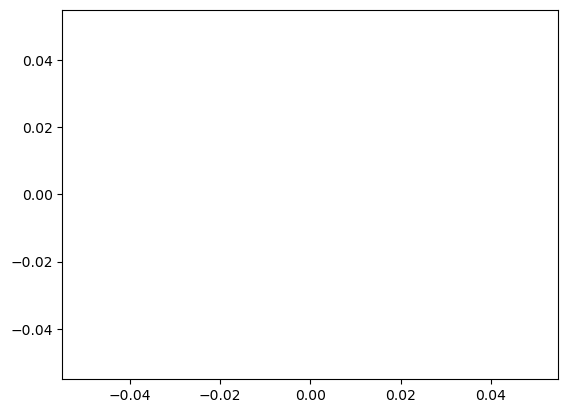

In [17]:
for ix_wdn, wdn in enumerate(all_wdn_names):
    print(f'\nWorking with {wdn}, network {ix_wdn+1} of {len(all_wdn_names)}')

    # retrieve wntr data
    tra_database, val_database, tst_database = load_raw_dataset(wdn, data_folder)
    # reduce training data
    # tra_database = tra_database[:int(len(tra_database)*cfg['tra_prc'])]
    if cfg['tra_num'] < len(tra_database):
        tra_database = tra_database[:cfg['tra_num']]

    # remove PES anomaly
    if wdn == 'PES':
        if len(tra_database)>4468:
            del tra_database[4468]
            print('Removed PES anomaly')
            print('Check',tra_database[4468].pressure.mean())

    # get GRAPH datasets    # later on we should change this and use normal scalers from scikit
    tra_dataset, A12_bar = create_dataset(tra_database)
    gn = GraphNormalizer()
    gn = gn.fit(tra_dataset)
    tra_dataset, _ = create_dataset(tra_database,normalizer=gn)
    val_dataset,_ = create_dataset(val_database,normalizer=gn)
    tst_dataset,_ = create_dataset(tst_database,normalizer=gn)
    node_size, edge_size = tra_dataset[0].x.size(-1), tra_dataset[0].edge_attr.size(-1)
    # number of nodes
    # n_nodes=tra_dataset[0].x.shape[0]
    n_nodes=(1-tra_database[0].type_1H).numpy().sum() # remove reservoirs
    # dataloader
    # transform dataset for MLP
    # We begin with the MLP versions, when I want to add GNNs, check Riccardo's code
    A10,A12 = create_incidence_matrices(tra_dataset, A12_bar)
    tra_dataset_MLP, num_inputs, indices = create_dataset_MLP_from_graphs(tra_dataset)
    val_dataset_MLP = create_dataset_MLP_from_graphs(val_dataset)[0]
    tst_dataset_MLP = create_dataset_MLP_from_graphs(tst_dataset)[0]
    tra_loader = torch.utils.data.DataLoader(tra_dataset_MLP,
                                             batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset_MLP,
                                             batch_size=batch_size, shuffle=False, pin_memory=True)
    tst_loader = torch.utils.data.DataLoader(tst_dataset_MLP,
                                             batch_size=batch_size, shuffle=False, pin_memory=True)
    # loop through different algorithms
    n_epochs = num_inputs
    for algorithm in cfg['algorithms']:

        hyperParams = cfg['hyperParams'][algorithm]
        all_combinations = ParameterGrid(hyperParams)

        # create results dataframe
        results_df = pd.DataFrame(list(all_combinations))
        results_df = pd.concat([results_df,
                                pd.DataFrame(index=np.arange(len(all_combinations)),
                                          columns=list(res_columns))],axis=1)

        for i, combination in enumerate(all_combinations):
            print(f'{algorithm}: training combination {i+1} of {len(all_combinations)}\t',end='\r',)
            combination['indices'] = indices
            combination['num_outputs'] = n_nodes
            if algorithm == "UnrollingFinal":
                combination['A12'] = A12
                combination['A10'] = A10

            wandb.config = combination

            # model creation
            model = getattr(sys.modules[__name__], algorithm)(**combination).double().to(device)
            # print(model)
            total_parameters = sum(p.numel() for p in model.parameters())

            # model optimizer
            optimizer = optim.Adam(params=model.parameters(), **cfg['adamParams'])

            # training
            model, tra_losses, val_losses, elapsed_time, epochs = training(model, optimizer, tra_loader, val_loader,
                                                                    patience=10, report_freq=0, n_epochs=n_epochs,
                                                                   alpha=alpha, lr_rate=2, lr_epoch=100,
                                                                   normalization=None, path = f'{results_folder}/{wdn}/{algorithm}/')
            plot_loss(tra_losses,val_losses,f'{results_folder}/{wdn}/{algorithm}/loss/{i}')
            plot_R2(model,val_loader,f'{results_folder}/{wdn}/{algorithm}/R2/{i}')
            # store training history and model
            pd.DataFrame(data = np.array([tra_losses, val_losses]).T).to_csv(
                f'{results_folder}/{wdn}/{algorithm}/hist/{i}.csv')
            torch.save(model, f'{results_folder}/{wdn}/{algorithm}/models/{i}.csv')

            # compute and store predictions, compute r2 scores
            losses = {}
            r2_scores = {}
            for split, loader in zip(['training','validation','testing'],[tra_loader,val_loader,tst_loader]):
                losses[split], pred, real, test_time = testing(model, loader)
                r2_scores[split] = r2_score(real, pred)
                if i == 0:
                    pd.DataFrame(data=real.reshape(-1,n_nodes)).to_csv(
                        f'{results_folder}/{wdn}/{algorithm}/pred/{split}/real.csv') # save real obs
                pd.DataFrame(data=pred.reshape(-1,n_nodes)).to_csv(
                    f'{results_folder}/{wdn}/{algorithm}/pred/{split}/{i}.csv')

            # store results
            results_df.loc[i,res_columns] = (losses['training'], losses['validation'], losses['testing'],
                                             r2_scores['training'], r2_scores['validation'], r2_scores['testing'],
                                             total_parameters, elapsed_time,test_time, epochs)
        # # save graph normalizer
        # with open(f'{results_folder}/{wdn}/{algorithm}/gn.pickle', 'wb') as handle:
        #     pickle.dump(gn, handle, protocol=pickle.HIGHEST_PROTOCOL)
        results_df.to_csv(f'{results_folder}/{wdn}/{algorithm}/results_{algorithm}.csv')